<a href="https://colab.research.google.com/github/data-tamer2410/ds-house-price-predictor/blob/main/house_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,r2_score, root_mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split, ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
%matplotlib inline

# Task.

Build a stable model that predicts house prices based on their characteristics.

# Solving the task


## Loading data.

In [2]:
df = pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
df.agg(['min','max'])

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
min,1750000,1650,1,1,1,no,no,no,no,no,0,no,furnished
max,13300000,16200,6,4,4,yes,yes,yes,yes,yes,3,yes,unfurnished




*   **price**: real estate price (target variable);

*  **area**: area (square meter);

*  **bedrooms**: the number of bedrooms (1 - 6);

*  **bathrooms**: the number of bathrooms (1 - 4);

*  **stories**: the number of stories (floors) in the house (1 - 4);

*  **mainroom**: indicates if the property is located on a main road (yes/no);

*  **guestroom**: indicates if there is a guest room available (yes/no);

*  **basement**: indicates if the property has a basement (yes/no);

*  **hotwaterheating**: indicates if there is a hot water heating system (yes/no);

*  **airconditioning**: indicates if the property has air conditioning (yes/no);

*  **parking**: the number of parking spaces available (0 - 3);

*  **prefarea**: indicates if the property is in a preferred area (yes/no);

*  **furnishingstatus**: the status of the furnishings (e.g., furnished, semi-furnished, or unfurnished).







The dataset contains data about houses and their prices.

We will build a model that will predict the price of a house based on its characteristics.

## Data analysis and preparation.

### Check for missing values ​​in the data.

In [ ]:
df.isna().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


The data has no missing values, which is good.

### Encode data.

In [ ]:
df.dtypes

,0
price,int64
area,int64
bedrooms,int64
bathrooms,int64
stories,int64
mainroad,object
guestroom,object
basement,object
hotwaterheating,object
airconditioning,object


In the dataset, some columns have non-numeric values, let's encode them.

In [ ]:
label_encoder = LabelEncoder()

for col in df:
    if df[col].dtype == 'object':
        df[col] = label_encoder.fit_transform(df[col])

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0


We encode into numeric values ​​because machine learning algorithms only work with numeric values.

### Data normalization.

In [ ]:
df.agg(['min','max','mean','std'])

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.858716,0.177982,0.350459,0.045872,0.315596,0.693578,0.234862,1.069725
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.348635,0.382849,0.477552,0.209399,0.465180,0.861586,0.424302,0.761373


It can be seen that the features in our dataset have different scales:

*   **area**: from 1,650 to 16,200

*   **bedrooms**, **bathrooms**, **stories**: from 1 to 6 or 4

*   Binary signs (**mainroad**, **guestroom**, **basement**): here are 0 to 1

*   **parking**: from 0 to 3

*   **furnishingstatus**: from 0 to 2

This is bad because
there are some algorithms sensitive to the scale of the data.

We will solve this issue by normalizing the features using StandartScaler.

In [ ]:
targets = df['price']
features = df.drop(columns='price')  #for convenience, let's divide our data into the target variable and features.

In [ ]:
features_names = features.columns

features_scaler = StandardScaler()
features_norm = features_scaler.fit_transform(features)
features = pd.DataFrame(features_norm,columns=features_names)

features.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,1.046726,1.403419,1.421812,1.378217,0.405623,-0.465315,-0.734539,-0.219265,1.472618,1.517692,1.804941,-1.406286
1,1.757010,1.403419,5.405809,2.532024,0.405623,-0.465315,-0.734539,-0.219265,1.472618,2.679409,-0.554035,-1.406286
2,2.218232,0.047278,1.421812,0.224410,0.405623,-0.465315,1.361397,-0.219265,-0.679063,1.517692,1.804941,-0.091662
3,1.083624,1.403419,1.421812,0.224410,0.405623,-0.465315,1.361397,-0.219265,1.472618,2.679409,1.804941,-1.406286
4,1.046726,1.403419,-0.570187,0.224410,0.405623,2.149083,1.361397,-0.219265,1.472618,1.517692,-0.554035,-1.406286


### Checking correlations in the data.

In [ ]:
features.corrwith(targets) #correlation of features with the target variable.

,0
area,0.535997
bedrooms,0.366494
bathrooms,0.517545
stories,0.420712
mainroad,0.296898
guestroom,0.255517
basement,0.187057
hotwaterheating,0.093073
airconditioning,0.452954
parking,0.384394


The higher the correlation between the features and the target variable, the better, as some algorithms for regression problems require this.

In [ ]:
features.corr() #correlation between features

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
area,1.000000,0.151858,0.193820,0.083996,0.288874,0.140297,0.047417,-0.009229,0.222393,0.352980,0.234779,-0.171445
bedrooms,0.151858,1.000000,0.373930,0.408564,-0.012033,0.080549,0.097312,0.046049,0.160603,0.139270,0.079023,-0.123244
bathrooms,0.193820,0.373930,1.000000,0.326165,0.042398,0.126469,0.102106,0.067159,0.186915,0.177496,0.063472,-0.143559
stories,0.083996,0.408564,0.326165,1.000000,0.121706,0.043538,-0.172394,0.018847,0.293602,0.045547,0.044425,-0.104672
mainroad,0.288874,-0.012033,0.042398,0.121706,1.000000,0.092337,0.044002,-0.011781,0.105423,0.204433,0.199876,-0.156726
guestroom,0.140297,0.080549,0.126469,0.043538,0.092337,1.000000,0.372066,-0.010308,0.138179,0.037466,0.160897,-0.118328
basement,0.047417,0.097312,0.102106,-0.172394,0.044002,0.372066,1.000000,0.004385,0.047341,0.051497,0.228083,-0.112831
hotwaterheating,-0.009229,0.046049,0.067159,0.018847,-0.011781,-0.010308,0.004385,1.000000,-0.130023,0.067864,-0.059411,-0.031628
airconditioning,0.222393,0.160603,0.186915,0.293602,0.105423,0.138179,0.047341,-0.130023,1.000000,0.159173,0.117382,-0.150477
parking,0.352980,0.139270,0.177496,0.045547,0.204433,0.037466,0.051497,0.067864,0.159173,1.000000,0.091627,-0.177539


And in the case of correlation between features, on the contrary, it is better when the correlation is small, because large correlation values ​​between features can lead to multicollinearity, which increases the risk of overtraining.

In our dataset, there is no high correlation between traits.

### Data visualization.

Plot the graph of the dependence between the area and the target variable (price), and we will evaluate the dependence.

<Axes: xlabel='area', ylabel='price'>

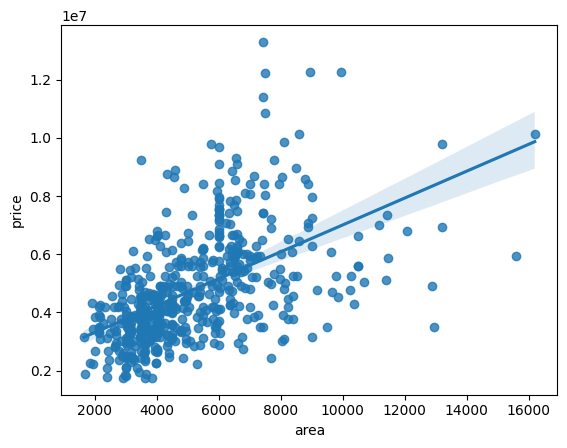

In [ ]:
sns.regplot(df,x='area',y='price')

The graph shows a growing regression line, which indicates a positive linear relationship between the area and the target price.

Let's look at the price distributions using a histogram.

<Axes: xlabel='price', ylabel='Count'>

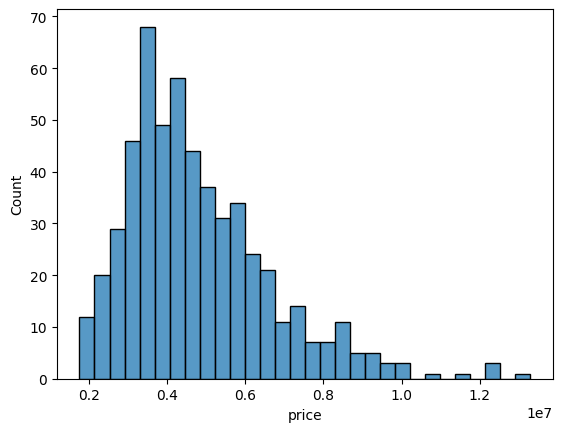

In [ ]:
sns.histplot(targets,bins=30)

As you can see, there are outliers, that is, a small number of prices for houses that differ significantly from the main mass of prices.

This can go wrong with algorithms sensitive to these outliers such as LinearRegressor, because the model will adjust for the outliers and have a not very good overall score on all the data.

But to make sure of the presence of these anomalies, we will build another graph (BoxenPlot).

<Axes: ylabel='price'>

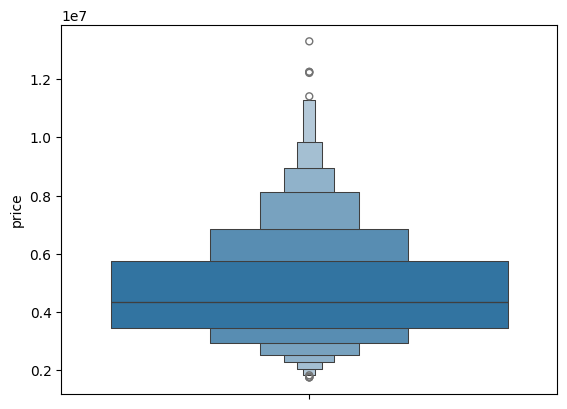

In [ ]:
sns.boxenplot(targets)

Dots on the graph are outliers.

### Data separation.

In order to properly assess the quality of our models, we will divide the data into training and test data.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features,targets,test_size=0.25,random_state=42)

## Construction of models.

### LinearRegression

In [ ]:
line_reg = LinearRegression(n_jobs=-1)

To evaluate the models, I will perform a cross-validation to detect overtraining if any, and a control test on the test data.

**CV test.**

In [ ]:
cv = ShuffleSplit(n_splits=10,test_size=0.25,random_state=3)
scores = cross_validate(line_reg,features,targets,scoring=['neg_root_mean_squared_error','neg_mean_absolute_error','r2'],cv=cv,n_jobs=-1,return_train_score=True)
scores_line_reg = {'RMSE': -scores["test_neg_root_mean_squared_error"].mean(),
                   'MAE': -scores["test_neg_mean_absolute_error"].mean(),
                   'R2': scores["test_r2"].mean()}

print('CV test:')
for metric,value in scores_line_reg.items():
    print(f'{metric}: {value:.4f}')

CV test:
RMSE: 1095661.2519
MAE: 817581.9344
R2: 0.6351


Let's check what estimates are on the training data.

In [ ]:
print(f'CV test on training data:\nRMSE: {-scores["train_neg_root_mean_squared_error"].mean():.4f}\n'
      f'MAE: {-scores["train_neg_mean_absolute_error"].mean():.4f}\n'
      f'R2: {scores["train_r2"].mean():.4f}')

CV test on training data:
RMSE: 1048977.3419
MAE: 767378.5140
R2: 0.6894


**Control test.**

In [ ]:
line_reg.fit(x_train,y_train)
y_pred = line_reg.predict(x_test)

print(f'Control test:\nRMSE: {root_mean_squared_error(y_test,y_pred):.4f}\n'
      f'MAE: {mean_absolute_error(y_test,y_pred):.4f}\n'
      f'R2: {r2_score(y_test,y_pred):.4f}')

Control test:
RMSE: 1249024.7582
MAE: 919520.6452
R2: 0.6615


It can be seen that the cross-validation estimates on the training data are slightly better than on the test data, this indicates retraining, but not critical.

**Model coef.**

In [ ]:
print(f'Coef LinearRegressor: {line_reg.coef_}')

Coef LinearRegressor: [ 520022.98285557   53248.68254328  565055.44825915  334449.73180286
  129517.26169348  104074.71330067  191559.48867826  144811.93337608
  356313.72677031  223365.30844427  266144.47805509 -157510.27894053]


**Visualization of the model work.**

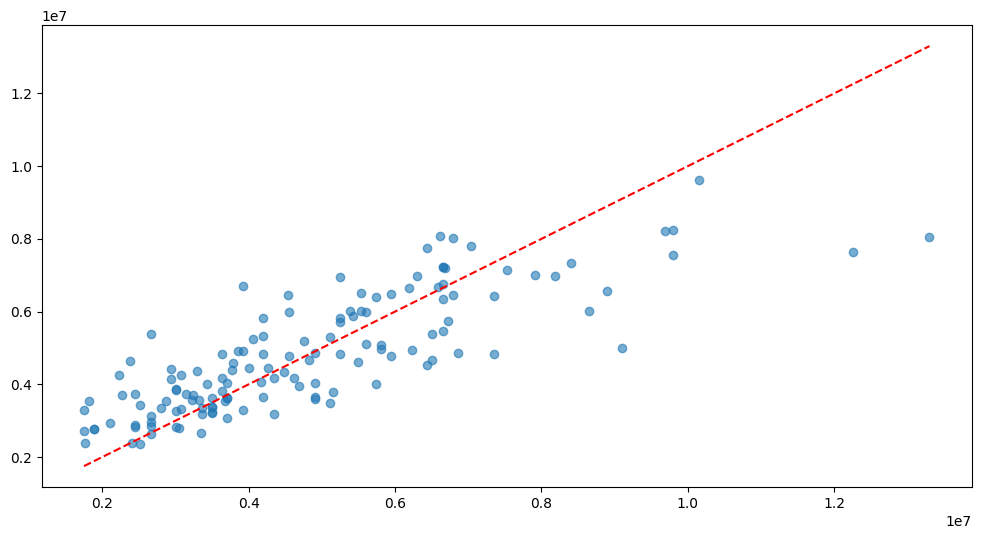

In [ ]:
plt.figure(figsize=(12,6))

plt.scatter(x=y_test,y=y_pred,alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

### Linear regression from zero.


For most understanding of the algorithm, I will build a linear regression from scratch.

In [ ]:
def predict(X,w):
    return X @ w


def gradient_step(X,y,w,alpha):
    m = len(y)
    prediction = predict(X,w)
    gradient =  X.T @ (prediction - y) / m
    new_w = w - alpha * gradient
    return new_w

The first coefficient of the linear model is the intercept, so we added a new feature filled with 1 for the intercept to our features.

In [ ]:
i_features = features.copy()
i_features.insert(0,column='intercept',value=np.ones(i_features.shape[0]))
i_features = i_features.to_numpy()
i_targets = targets.to_numpy()

i_x_train = x_train.copy()
i_x_train.insert(0,column='intercept',value=np.ones(i_x_train.shape[0]))
i_x_train = i_x_train.to_numpy()
i_y_train = y_train.to_numpy()

i_x_test = x_test.copy()
i_x_test.insert(0,column='intercept',value=np.ones(i_x_test.shape[0]))
i_x_test = i_x_test.to_numpy()
i_y_test = y_test.to_numpy()

**Selection of hyperparameters using optuna.**


In [ ]:
def objective(trial):
    n_iters = trial.suggest_int('n_iters',10,1000)
    alpha = trial.suggest_float('alpha',0.00001,1)

    cv = ShuffleSplit(n_splits=10,test_size=0.25,random_state=5)

    rmse_list = []

    for i_train, i_test in cv.split(i_features):
        x_train = i_features[i_train]
        y_train = i_targets[i_train]

        x_test = i_features[i_test]
        y_test = i_targets[i_test]

        w = np.random.rand(x_train.shape[1])
        for _ in range(n_iters):
            w = gradient_step(x_train,y_train,w,alpha)

        y_pred = predict(x_test,w)
        rmse_list.append(root_mean_squared_error(y_test,y_pred))
    return np.mean(rmse_list)

study = optuna.create_study(direction='minimize',pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=100,n_jobs=-1,show_progress_bar=True)

In [ ]:
print(f'Best params: {study.best_params}\nBest value: {study.best_value}')

Best params: {'n_iters': 471, 'alpha': 0.015431322501967742}
Best value: 1132574.302351724


In [ ]:
n_iters = 471
alpha = 0.015431322501967742

**CV test.**

In [ ]:
cv = ShuffleSplit(n_splits=10,test_size=0.25,random_state=54)

rmse_test_list = []
mae_test_list = []
r2_test_list = []

rmse_train_list = []
mae_train_list = []
r2_train_list = []

for i_train, i_test in cv.split(i_features):
    features_train = i_features[i_train]
    targets_train = i_targets[i_train]

    features_test = i_features[i_test]
    targets_test = i_targets[i_test]

    w = np.random.rand(features_train.shape[1])
    for _ in range(n_iters):
        w = gradient_step(features_train,targets_train,w,alpha)

    y_test_pred = predict(features_test,w)

    rmse_test_list.append(root_mean_squared_error(targets_test,y_test_pred))
    mae_test_list.append(mean_absolute_error(targets_test,y_test_pred))
    r2_test_list.append(r2_score(targets_test,y_test_pred))

    y_train_pred = predict(features_train,w)

    rmse_train_list.append(root_mean_squared_error(targets_train,y_train_pred))
    mae_train_list.append(mean_absolute_error(targets_train,y_train_pred))
    r2_train_list.append(r2_score(targets_train,y_train_pred))

scores_line_reg_zero = {'RMSE': np.mean(rmse_test_list),
                        'MAE': np.mean(mae_test_list),
                        'R2': np.mean(r2_test_list)}

print('CV test:')
for metric,value in scores_line_reg_zero.items():
    print(f'{metric}: {value:.4f}')

CV test:
RMSE: 1114398.0484
MAE: 823742.0093
R2: 0.6550


In [ ]:
print(f'CV test on training data:\nRMSE: {np.mean(rmse_train_list):.4f}\n'
      f'MAE: {np.mean(mae_train_list):.4f}\n'
      f'R2: {np.mean(r2_train_list):.4f}')

CV test on training data:
RMSE: 1041675.3447
MAE: 763236.1098
R2: 0.6836


**Training and control test.**

In [ ]:
rmse_list = []
mae_list = []
r2_list = []

w = np.random.rand(i_features.shape[1])
for i in range(n_iters):
    y_pred = predict(i_x_train, w)

    rmse_list.append(root_mean_squared_error(i_y_train,y_pred))
    mae_list.append(mean_absolute_error(i_y_train,y_pred))
    r2_list.append(r2_score(i_y_train,y_pred))

    w = gradient_step(i_x_train,i_y_train,w,alpha)
    if i % 100 == 0 or i == n_iters - 1:
        print(f'Iter: {i}\nRMSE: {rmse_list[-1]:.4f}\n'
              f'MAE: {mae_list[-1]:.4f}\n'
              f'R2: {r2_list[-1]:.4f}\n')

Iter: 0
RMSE: 5068604.8871
MAE: 4751248.9529
R2: -7.2437

Iter: 100
RMSE: 1428798.7818
MAE: 1130743.4648
R2: 0.3449

Iter: 200
RMSE: 1019542.6348
MAE: 746423.8446
R2: 0.6665

Iter: 300
RMSE: 994353.8820
MAE: 727748.4905
R2: 0.6827

Iter: 400
RMSE: 992697.5676
MAE: 727137.4552
R2: 0.6838

Iter: 470
RMSE: 992549.3685
MAE: 726981.1458
R2: 0.6839



In [ ]:
y_pred = predict(i_x_test,w)

print(f'Control test:\nRMSE: {root_mean_squared_error(i_y_test,y_pred):.4f}\n'
      f'MAE: {mean_absolute_error(i_y_test,y_pred):.4f}\n'
      f'R2: {r2_score(i_y_test,y_pred):.4f}')

Control test:
RMSE: 1247948.3177
MAE: 917251.3145
R2: 0.6620


**Model coef.**

In [ ]:
print(f'Coef linear regression (zero): {w}')

Coef linear regression (zero): [4763333.99472868  517288.92236932   62071.43475183  559142.3349145
  327691.40437236  132198.46646528  107509.36923568  186744.53068777
  145389.3172008   358312.0507989   223897.37253435  264923.84791675
 -159000.23168034]


**Visualization of the model work.**

Let's build a graph that demonstrates how the algorithm reduces the loss function (RMSE) with learning.

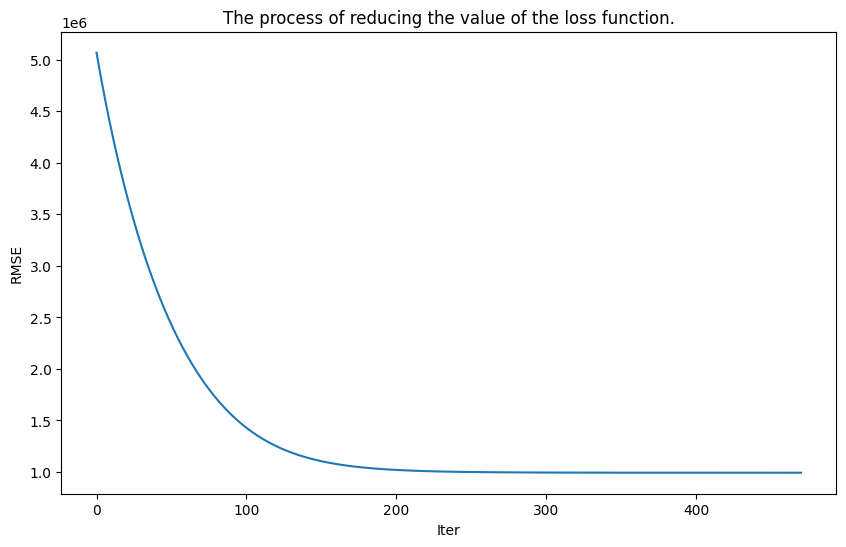

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(n_iters),rmse_list)

plt.title('The process of reducing the value of the loss function.')
plt.ylabel('RMSE')
plt.xlabel('Iter')

plt.show()

### Analytical solution for finding parameters.

We will use the same hyperparameters as in the previous model.

We immediately do cross-validation and a control test.

**CV test.**

In [ ]:
cv = ShuffleSplit(n_splits=10,test_size=0.25,random_state=54)

rmse_list = []
mae_list = []
r2_list = []

for i_train, i_test in cv.split(i_features):
    features_train = i_features[i_train]
    targets_train = i_targets[i_train]

    features_test = i_features[i_test]
    targets_test = i_targets[i_test]

    w = np.linalg.inv((features_train.T @ features_train)) @ (features_train.T @ targets_train)

    y_pred = predict(features_test,w)

    rmse_list.append(root_mean_squared_error(targets_test,y_pred))
    mae_list.append(mean_absolute_error(targets_test,y_pred))
    r2_list.append(r2_score(targets_test,y_pred))


scores_line_reg_analysis = {'RMSE': np.mean(rmse_list),
                            'MAE': np.mean(mae_list),
                            'R2': np.mean(r2_list)}

print('CV test:')
for metric,value in scores_line_reg_analysis.items():
    print(f'{metric}: {value:.4f}')

CV test:
RMSE: 1114879.6457
MAE: 824206.1228
R2: 0.6547


**Control test.**

In [ ]:
w = np.linalg.inv((i_x_train.T @ i_x_train)) @ (i_x_train.T @ i_y_train)
y_pred = predict(i_x_test,w)

print(f'Control test:\nRMSE: {root_mean_squared_error(i_y_test,y_pred):.4f}\n'
      f'MAE: {mean_absolute_error(i_y_test,y_pred):.4f}\n'
      f'R2: {r2_score(i_y_test,y_pred):.4f}')

Control test:
RMSE: 1249024.7582
MAE: 919520.6452
R2: 0.6615


**Visualization of the model work.**

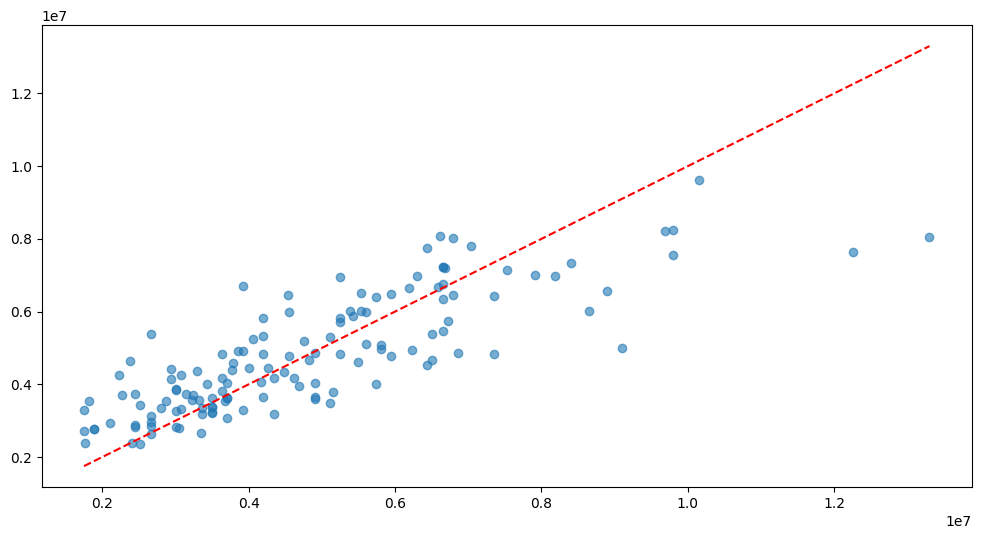

In [ ]:
plt.figure(figsize=(12,6))

plt.scatter(x=y_test,y=y_pred,alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

### Lasso

Let's try another linear regression algorithm — Lasso (Least Absolute Shrinkage and Selection Operator), which differs in that it adds L1 regularization to the loss function. This means that the model tries to minimize the sum of the squared errors between the predictions and the actual values ​​(as in normal linear regression), but also penalizes large regression coefficients. Thus, Lasso helps reduce the weight of insignificant features until they are completely zero, which effectively performs feature selection.

**Selection of hyperparameters using optuna.**


In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha',0.00001,100)

    cv = ShuffleSplit(n_splits=10,test_size=0.25,random_state=9)
    algo = Lasso(alpha=alpha,random_state=42)

    scores = cross_validate(algo,features,targets,n_jobs=-1,cv=cv,scoring=['neg_root_mean_squared_error'])
    return -scores['test_neg_root_mean_squared_error'].mean()

study = optuna.create_study(direction='minimize',pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=100,n_jobs=-1,show_progress_bar=True)

In [ ]:
print(f'Best params: {study.best_params}\nBest value: {study.best_value}')

Best params: {'alpha': 99.91926857210738}
Best value: 1091153.6792186531


In [ ]:
lasso = Lasso(alpha=100,random_state=33)

**CV test.**

In [ ]:
cv = ShuffleSplit(n_splits=10,test_size=0.25,random_state=43)
scores = cross_validate(lasso,features,targets,scoring=['neg_root_mean_squared_error','neg_mean_absolute_error','r2'],cv=cv,n_jobs=-1,return_train_score=True)
scores_lasso = {'RMSE': -scores["test_neg_root_mean_squared_error"].mean(),
                'MAE': -scores["test_neg_mean_absolute_error"].mean(),
                'R2': scores["test_r2"].mean()}

print('CV test:')
for metric,value in scores_lasso.items():
    print(f'{metric}: {value:.4f}')

CV test:
RMSE: 1056228.5534
MAE: 768210.7474
R2: 0.6831


In [ ]:
print(f'CV test on training data:\nRMSE: {-scores["train_neg_root_mean_squared_error"].mean():.4f}\n'
      f'MAE: {-scores["train_neg_mean_absolute_error"].mean():.4f}\n'
      f'R2: {scores["train_r2"].mean():.4f}')

CV test on training data:
RMSE: 1061022.0018
MAE: 781197.8968
R2: 0.6738


**Control test.**

In [ ]:
lasso.fit(x_train,y_train)
y_pred = lasso.predict(x_test)

print(f'Control test\nRMSE: {root_mean_squared_error(y_test,y_pred):.4f}\n'
      f'MAE: {mean_absolute_error(y_test,y_pred):.4f}\n'
      f'R2: {r2_score(y_test,y_pred):.4f}')

Control test
RMSE: 1249067.4486
MAE: 919522.2127
R2: 0.6614


**Model coef.**

In [ ]:
print(f'Coef Lasso: {lasso.coef_}')

Coef Lasso: [ 520001.09316714   53231.94510797  565013.98539375  334385.34011636
  129465.16062454  104035.86852275  191490.81347683  144715.86051158
  356275.15693641  223318.68786424  266090.94770477 -157471.95840855]


**Visualization of the model work.**

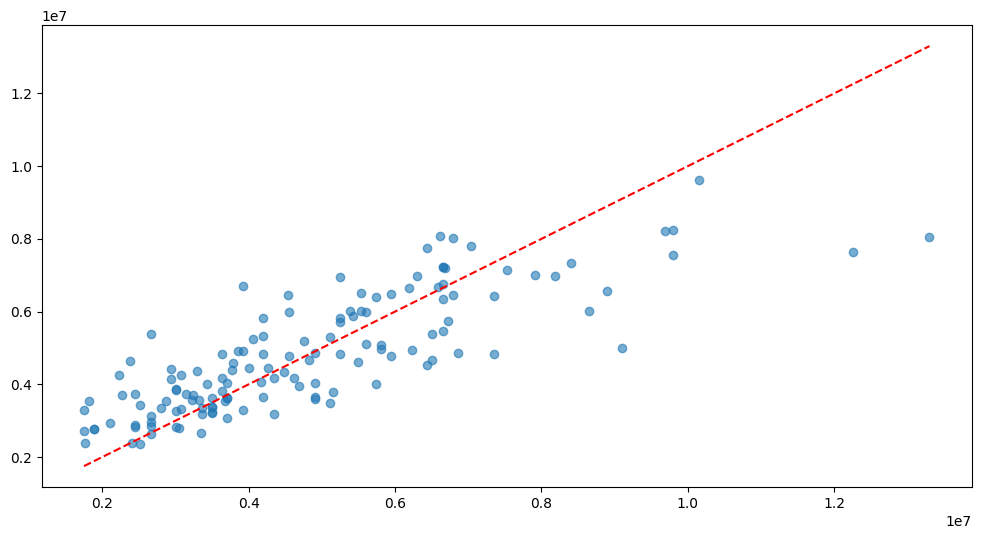

In [ ]:
plt.figure(figsize=(12,6))

plt.scatter(x=y_test,y=y_pred,alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

### RandomForestRegressor

And the next algorithm we will test is RandomForestRegressor, a robust ensemble learning method that operates by constructing multiple decision trees during training and outputting the average prediction (for regression tasks). Random forests reduce overfitting by averaging the predictions of multiple trees and tend to perform well on datasets with complex relationships or non-linearities between features.

Minimum number of samples in a leaf node (min_samples_leaf): This parameter specifies the minimum number of samples that must be present in a leaf node. It helps prevent the creation of leaf nodes with very few samples, which can lead to overfitting. A higher value makes the model more generalized.

Minimum number of samples required to split a node (min_samples_split): This defines the minimum number of samples needed in a node before it can be split into smaller nodes. If the number of samples is below this threshold, the node won’t be split. A larger value prevents the tree from growing too complex.

Number of trees in the forest (n_estimators): This is the number of decision trees that the RandomForest algorithm will build. A higher number usually improves performance but increases computation time. Each tree learns a different part of the data, and the final prediction is the aggregate of all trees’ predictions.

Number of samples for each tree (max_samples): This specifies the number of samples that each tree will be trained on. If not set, each tree will use all samples. It can be a fixed number or a percentage of the total samples (e.g., max_samples=0.8 means each tree will use 80% of the samples).

Number of features considered for each split (max_features): This parameter controls how many features are considered when searching for the best split at each node. It can be set as a fixed number, a percentage of the total features, or a function (e.g., sqrt or log2).

Maximum depth of the tree (max_depth): This limits how deep each tree can grow. Limiting the depth helps prevent overfitting, as deep trees can capture too many details from the training data, potentially harming generalization on unseen data.

These are critical hyperparameters that need to be carefully tuned to optimize the performance of a RandomForest model.

**Selection of hyperparameters using optuna.**

I run the tests several times gradually decreasing the range of hyperparameter values ​​to find the best hyperparameters for the model.

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',120,130)
    min_samples_split = trial.suggest_int('min_samples_split',3,5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',4,5)
    max_features = trial.suggest_float('max_features', 0.9,0.93)
    max_samples = trial.suggest_float('max_samples',0.5,0.515)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=None,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  max_features=max_features,
                                  max_samples=max_samples,
                                  n_jobs=-1,random_state=43)

    cv = ShuffleSplit(n_splits=10,test_size=0.25,random_state=22)

    scores = cross_validate(model,features,targets,scoring=['neg_root_mean_squared_error'],
                            cv=cv,n_jobs=-1)
    return -scores['test_neg_root_mean_squared_error'].mean()

study = optuna.create_study(direction='minimize',pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=50,n_jobs=-1,show_progress_bar=True)

In [ ]:
print(f'Best params: {study.best_params}\nBest value: {study.best_value}')

Best params: {'n_estimators': 125, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.9235169903498044, 'max_samples': 0.5053643178287779}
Best value: 1110539.116462564


In [ ]:
forest = RandomForestRegressor(n_estimators=125,
                               max_depth=None,
                               min_samples_split=4,
                               min_samples_leaf=4,
                               max_features=0.9235169903498044,
                               max_samples=0.5053643178287779,
                               n_jobs=-1,random_state=43)

**CV test.**

In [ ]:
cv = ShuffleSplit(n_splits=10,test_size=0.3,random_state=22)
scores = cross_validate(forest,features,targets,scoring=['neg_root_mean_squared_error',
                                                         'neg_mean_absolute_error',
                                                         'r2'],
                                                         cv=cv,n_jobs=-1,return_train_score=True)

scores_forest = {'RMSE': -scores["test_neg_root_mean_squared_error"].mean(),
                 'MAE': -scores["test_neg_mean_absolute_error"].mean(),
                 'R2': scores["test_r2"].mean()}

print('CV test:')
for metric,value in scores_forest.items():
    print(f'{metric}: {value:.4f}')

CV test:
RMSE: 1173384.9640
MAE: 827325.7326
R2: 0.6253


In [ ]:
print(f'CV test on training data:\nRMSE: {-scores["train_neg_root_mean_squared_error"].mean():.4f}\n'
      f'MAE: {-scores["train_neg_mean_absolute_error"].mean():.4f}\n'
      f'R2: {scores["train_r2"].mean():.4f}')

CV test on training data:
RMSE: 952391.8311
MAE: 677050.8892
R2: 0.7330


You can see that the model is being retrained a little.

**Control test.**

In [ ]:
forest.fit(x_train,y_train)
y_pred = forest.predict(x_test)

print(f'Control test:\nRMSE: {root_mean_squared_error(y_test,y_pred):.4f}\n'
      f'MAE: {mean_absolute_error(y_test,y_pred):.4f}\n'
      f'R2: {r2_score(y_test,y_pred):.4f}')

Control test:
RMSE: 1360837.4556
MAE: 1021244.5331
R2: 0.5981


In [ ]:
forest.feature_importances_

array([0.51889931, 0.02906049, 0.17321911, 0.0417836 , 0.00582121,
       0.01383403, 0.02848726, 0.00330225, 0.07143503, 0.04548266,
       0.02286812, 0.04580694])

**Visualization of the model work.**

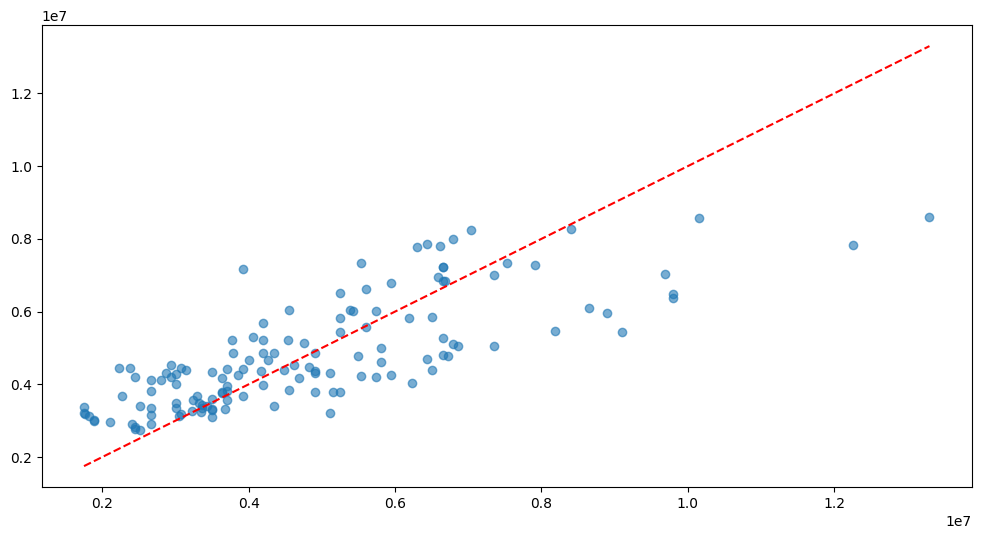

In [ ]:
plt.figure(figsize=(12,6))

plt.scatter(x=y_test,y=y_pred,alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

### GradientBoostingRegressor

Gradient Boosting for regression builds a strong model by combining many weak models (decision trees) that learn from the errors of previous models. It adjusts predictions gradually to improve accuracy.

**Selection of hyperparameters using optuna.**

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',145,175)
    learning_rate = trial.suggest_float('learning_rate',0.033,0.045)
    max_depth = trial.suggest_int('max_depth',3,6)
    subsample = trial.suggest_float('subsample',0.55,0.75)
    min_samples_split = trial.suggest_int('min_samples_split',2,11)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,4)
    max_features = trial.suggest_float('max_features',0.35,0.41)
    alpha = trial.suggest_float('alpha',0.85,0.88)

    model = GradientBoostingRegressor(n_estimators = n_estimators,
                                      learning_rate = learning_rate,
                                      max_depth = max_depth,
                                      subsample = subsample,
                                      min_samples_split = min_samples_split,
                                      min_samples_leaf = min_samples_leaf,
                                      max_features = max_features,
                                      alpha = alpha,random_state=34)

    cv = ShuffleSplit(n_splits=10,test_size=0.25,random_state=22)

    scores = cross_validate(model,features,targets,scoring=['neg_root_mean_squared_error'],
                            cv=cv,n_jobs=-1)
    return -scores['test_neg_root_mean_squared_error'].mean()

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=50,n_jobs=-1,show_progress_bar=True)

In [ ]:
print(f'Best params: {study.best_params}\nBest value: {study.best_value}')

Best params: {'n_estimators': 153, 'learning_rate': 0.039414461283773974, 'max_depth': 4, 'subsample': 0.5901402789046466, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.3599075987250444, 'alpha': 0.8711857459424042}
Best value: 1074724.6516526877


In [ ]:
gb = GradientBoostingRegressor(n_estimators=153,
                               learning_rate=0.039414461283773974,
                               max_depth=4,
                               subsample=0.5901402789046466,
                               min_samples_split=8,
                               min_samples_leaf=1,
                               max_features=0.3599075987250444,
                               alpha=0.8711857459424042)

**CV test.**

In [ ]:
cv = ShuffleSplit(n_splits=10,test_size=0.3,random_state=22)
scores = cross_validate(gb,features,targets,scoring=['neg_root_mean_squared_error',
                                                         'neg_mean_absolute_error',
                                                         'r2'],
                                                         cv=cv,n_jobs=-1,return_train_score=True)

scores_gb = {'RMSE': -scores["test_neg_root_mean_squared_error"].mean(),
                 'MAE': -scores["test_neg_mean_absolute_error"].mean(),
                 'R2': scores["test_r2"].mean()}

print('CV test:')
for metric,value in scores_gb.items():
    print(f'{metric}: {value:.4f}')

CV test:
RMSE: 1089761.3512
MAE: 776995.0883
R2: 0.6763


In [ ]:
print(f'CV test on training data:\nRMSE: {-scores["train_neg_root_mean_squared_error"].mean():.4f}\n'
      f'MAE: {-scores["train_neg_mean_absolute_error"].mean():.4f}\n'
      f'R2: {scores["train_r2"].mean():.4f}')

CV test on training data:
RMSE: 710042.0171
MAE: 530230.8720
R2: 0.8516


**Control test.**

In [ ]:
gb.fit(x_train,y_train)
y_pred = gb.predict(x_test)

print(f'Control test:\nRMSE: {root_mean_squared_error(y_test,y_pred):.4f}\n'
      f'MAE: {mean_absolute_error(y_test,y_pred):.4f}\n'
      f'R2: {r2_score(y_test,y_pred):.4f}')

Control test:
RMSE: 1277959.4416
MAE: 917304.4042
R2: 0.6456


In [ ]:
gb.feature_importances_

array([0.34460479, 0.05708285, 0.18117433, 0.07034336, 0.02027618,
       0.01986069, 0.03576371, 0.02783896, 0.0936727 , 0.07894033,
       0.02794755, 0.04249455])

**Visualization of the model work.**

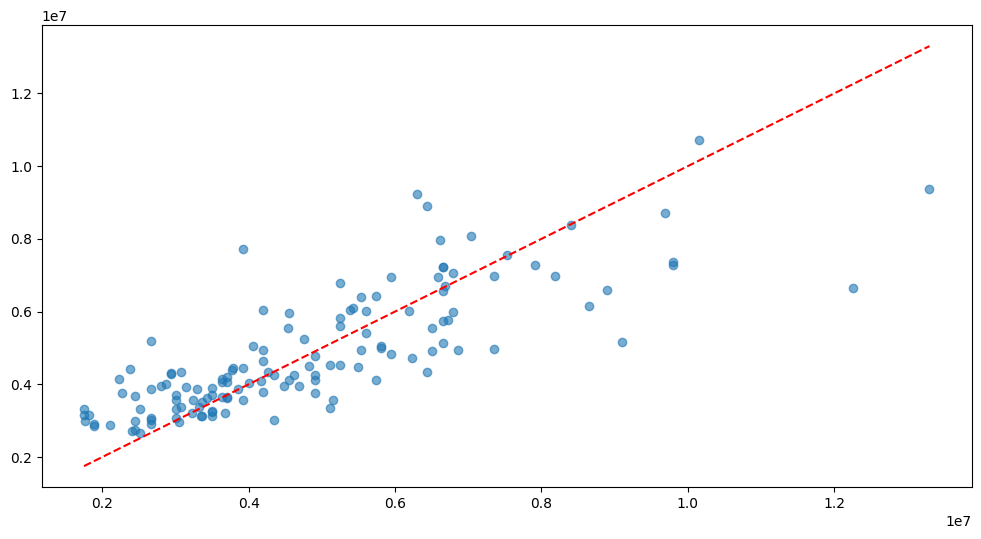

In [ ]:
plt.figure(figsize=(12,6))

plt.scatter(x=y_test,y=y_pred,alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

## Evaluation of algorithms.


Let's prepare estimates for visualization.

In [ ]:
models = ['Linear Regression', 'Linear Regression (Zero)', 'Linear Regression (Analysis)', 'Lasso', 'Random Forest','Gradient Boosting']
all_scores = (scores_line_reg,
              scores_line_reg_zero,
              scores_line_reg_analysis,
              scores_lasso,
              scores_forest,
              scores_gb)

all_rmse = [score['RMSE'] for score in all_scores]
all_mae = [score['MAE'] for score in all_scores]
all_r2 = [score['R2'] for score in all_scores]

for model,rmse_one,mae_one,r2_one in zip(models,all_rmse,all_mae,all_r2):
    print(f'{model}:\nRMSE: {rmse_one:.4f}\nMAE: {mae_one:.4f}\nR2: {r2_one:.4f}\n')

Linear Regression:
RMSE: 1095661.2519
MAE: 817581.9344
R2: 0.6351

Linear Regression (Zero):
RMSE: 1114398.0484
MAE: 823742.0093
R2: 0.6550

Linear Regression (Analysis):
RMSE: 1114879.6457
MAE: 824206.1228
R2: 0.6547

Lasso:
RMSE: 1056228.5534
MAE: 768210.7474
R2: 0.6831

Random Forest:
RMSE: 1173384.9640
MAE: 827325.7326
R2: 0.6253

Gradient Boosting:
RMSE: 1089761.3512
MAE: 776995.0883
R2: 0.6763



**We compare RMSE and MAE between different models.**

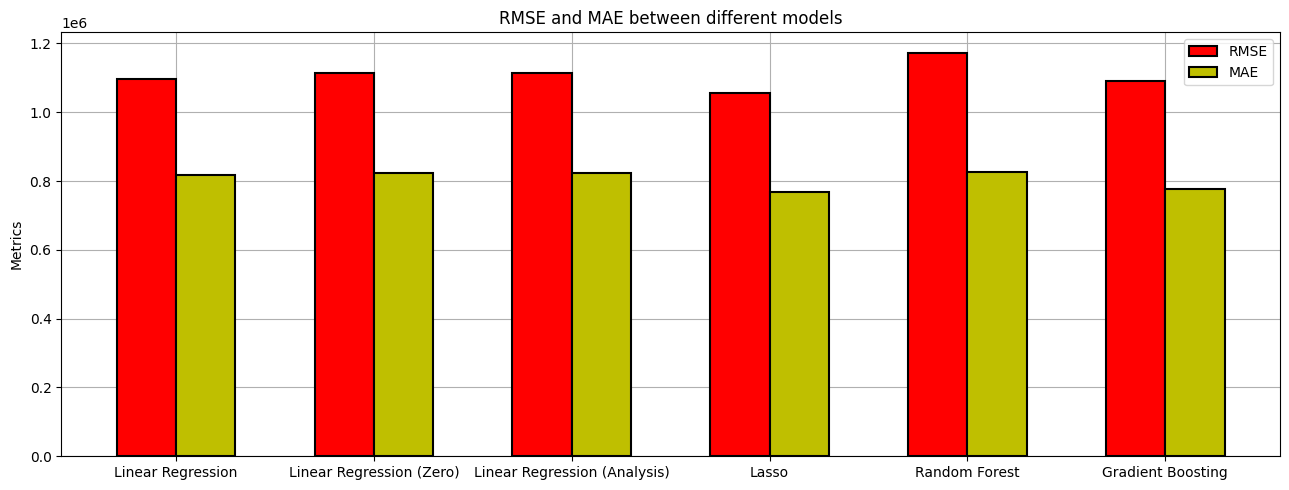

In [ ]:
plt.figure(figsize=(13,5))

x = np.arange(len(all_scores))
width = 0.3

plt.bar(x=x - width / 2,height=all_rmse,width=width,color='r',edgecolor='black',linewidth=1.5,label='RMSE',zorder=2)

plt.bar(x=x + width / 2,height=all_mae,width=width,color='y',edgecolor='black',linewidth=1.5,label='MAE',zorder=3)

plt.title('RMSE and MAE between different models')
plt.xticks(x,models)
plt.ylabel('Metrics')

plt.grid(zorder=1)
plt.tight_layout()
plt.legend()
plt.show()

**And now let's compare R2.**

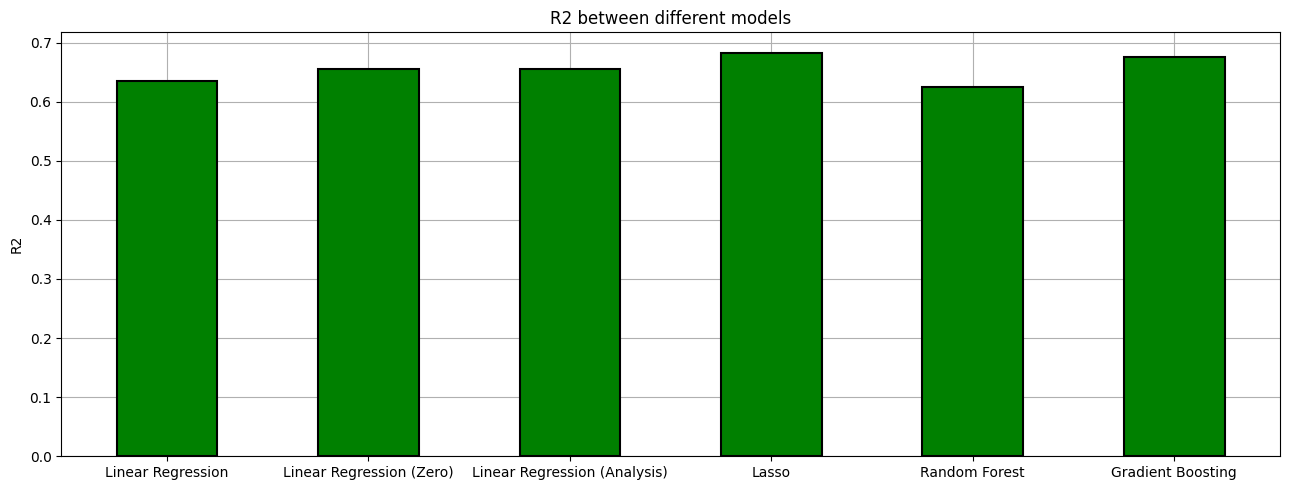

In [ ]:
plt.figure(figsize=(13,5))

x = np.arange(len(all_scores))
width = 0.5

plt.bar(x=x,height=all_r2,width=width,color='g',edgecolor='black',linewidth=1.5,zorder=2)

plt.title('R2 between different models')
plt.xticks(x,models)
plt.ylabel('R2')

plt.grid(zorder=1)
plt.tight_layout()
plt.show()

# Conclusion.

Based on the results obtained, the Lasso model showed the best results in all metrics, which indicates its effectiveness for this task. Gradient boosting also shows good results and can be considered as an alternative. Linear regression and random forest models showed less satisfactory results.